# Propensity Score Matching Example

This following example follows the example given in the original <code>PyMatch</code> [package](https://github.com/benmiroglio/pymatch). The example will use the [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) from Kaggle. The original package and example focuses on homogeneous dependent variables, such as data exclusively fully paid off loans or fully defaulted loans. Our work data usually contains dichotomous outcomes: 1 *or* 0. This reworked package attempts to make that fix.

In this example, we will randomly sample **Fully Paid Off** loans and **Defaulted** loans. As this is a large data set with millions of observations, random sampling will help matching purely for the sake of time and visual. This example will only go through the matching and show the matched data.


## 1. Data Preparation

In [1]:
import warnings
import numpy as np
import pandas as pd
import pymatch_ds.functions as uf
from pymatch_ds.Matcher import Matcher

# suppress all the pandas re-indexing warnings
warnings.filterwarnings('ignore')

Load the dataset, select the fields of interest.

In [2]:
path = 'loan.csv'
#take columns of interest
fields = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
          'installment', 'grade', 'sub_grade', 'annual_inc', 'loan_status',
          'hardship_flag']
source = pd.read_csv(path)[fields]
source.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,annual_inc,loan_status,hardship_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,55000.0,Current,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,90000.0,Current,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,59280.0,Current,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,92000.0,Current,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,57250.0,Current,N


For the sake of this matching, we will treat all long late loans (classified as those 31-120 days late) as defaulted as well. Although this is a categorical variable, this such a variable would work better as a continuous variable designated by "how late". Regardless, we'll reclassify and split the Fully Paid and Defaulted Loans.

In [3]:
source['loan_status'] = source['loan_status'].replace('Late (31-120 days)', 'Default')
fully_paid = source[source['loan_status'] == 'Fully Paid']
default = source[source['loan_status'] == 'Default']

With the 2 datasets created, we will create 2 "banks" worth of data. We will combine the data together. From there, the data will be randomly sampled into a test data set (Bank 1) and a control data set (Bank 2). Observations found in Bank 1 will be excluded from Bank 2 thus they can be truly independent of each other.

In [4]:
# sample 20k records from fully paid and 2k from defaulted
df = fully_paid.sample(20000, random_state = 42).append(default.sample(2000, random_state = 42))
test = df.sample(1000, replace = True, random_state = 43)
control = df.sample(10000, replace = True, random_state = 21)
test = test[~test.index.isin(control.index)]
test.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,annual_inc,loan_status,hardship_flag
1887782,20000,20000,20000.0,36 months,8.67,632.93,B,B1,80000.0,Fully Paid,N
1943813,6000,6000,6000.0,36 months,24.50,236.98,F,F3,45000.0,Fully Paid,N
802313,7000,7000,7000.0,36 months,8.49,220.95,B,B1,42000.0,Fully Paid,N
1932713,6000,6000,6000.0,36 months,14.49,206.50,C,C4,150000.0,Fully Paid,N
507701,5600,5600,5600.0,36 months,9.49,179.36,B,B2,45000.0,Fully Paid,N


The data sets will have indicator variables appended to them so figuring out which dataset they are from is simple. Furthermore, as propensity score matching is done via logistic regression, the dependent variable, <code>loan_status</code> will be recoded to 0 and 1 for Fully Paid and Defaulted loans respectively.

In [5]:
# add indicator variables to datasets for data set source
test['set_num'] = 1
control['set_num'] = 2

# change loan_status to binary
test['loan_status'] = test['loan_status'].replace(['Fully Paid', 'Default'], 
                                                  [0, 1])
control['loan_status'] = control['loan_status'].replace(['Fully Paid', 'Default'], 
                                                  [0, 1])
test.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,annual_inc,loan_status,hardship_flag,set_num
1887782,20000,20000,20000.0,36 months,8.67,632.93,B,B1,80000.0,0,N,1
1943813,6000,6000,6000.0,36 months,24.50,236.98,F,F3,45000.0,0,N,1
802313,7000,7000,7000.0,36 months,8.49,220.95,B,B1,42000.0,0,N,1
1932713,6000,6000,6000.0,36 months,14.49,206.50,C,C4,150000.0,0,N,1
507701,5600,5600,5600.0,36 months,9.49,179.36,B,B2,45000.0,0,N,1


## 2. Fit the Propensity Score Model

The package's main <code>Matcher</code> will be used for the brunt of the matching. Upon initialization, the object will print the formula for the logistic regression model for the probability of defaulting on a loan. All the variables on the right side of the ~ are the predictors. The number of observations in the test set and control set (from where we want to match) will also be provided. 

In [6]:
model = Matcher(test, control, yvar = 'loan_status', ds = 'set_num')
np.random.seed(20200625) #reproducibility

Formula:
loan_status ~ loan_amnt + funded_amnt + funded_amnt_inv + term + int_rate + installment + grade + sub_grade + annual_inc + hardship_flag
n base:  631
n to match:  10000


Since there are so few observations in our base set compared to our control set, we will specify the argument <code>balance = True</code> such that the sampling from the larger control set is equal in group size. Logistic regression models are run on the matches as a feature extraction tool, or the generation of propensity scores. Thus, it would be good practice to run more than one model as an argument in the <code>fit_scores</code> method. If the number of models isn't specified, the module auto calculates an appropriate number.

In [7]:
model.fit_scores(balance = True)

Static columns dropped: [] Samples: 20\20
Average Accuracy: 86.43%


No columns are dropped for being homogeneous and 20 models are run.

## 3. Predict the Scores

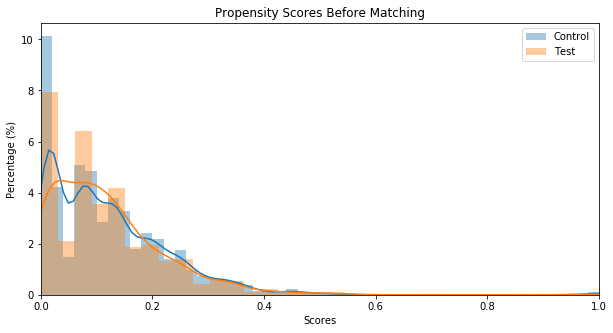

In [8]:
model.predict_scores()
model.plot_scores()

The plot of the propensity scores show that, more or less, both the test and control sets have similar probabilities for their loan members to default on the loan. Intuitively, that is to be expected, as we sampled random paid and defaulted loans and mashed them together to make a data set. And that's fine - for this type of matching, the score distribution should not matter *too* much. Our ultimate goal is the couple each observation with the closest matching observation from the control set.

The next step is to calculate a threshold. What minimum value of differences in propensity scores can we have, retain our matches, and still retain a maximum of test data set data?

This paragraph is lifted directly from the original <code>PyMatch</code> package example with a couple changes that more appropriately define our type of matching:  
By default matches are found *from* the majority group *for* the minority group. For example, if our test group contains 1,000 records and our control group contains 20,000, Matcher will iterate through the test group and find suitable matches from the control group. If a record in the minority group has no suitable matches, it is dropped from the final matched dataset. We need to ensure our threshold is small enough such that we get close matches and retain most (or all) of our data in the test group.

Keep in mind as datasets get larger, the time it takes for the tuner and fitter to run increases quickly as they iterate through every single observation, and multiple times.

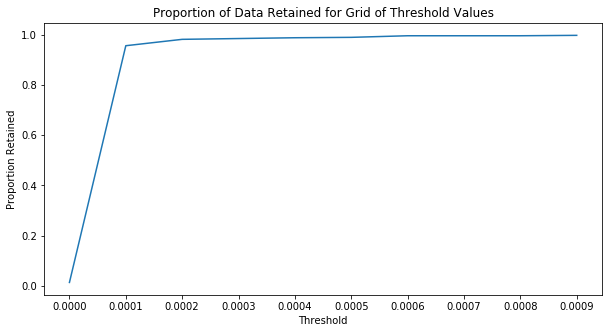

In [9]:
model.tune_threshold(method = 'random') #max threshold of 0.0002

Looks like a threshold value of 0.0002 retains 100% of the data. Thus we will use this threshold to perform the actual matching.

## 4. Match Data

Data is matched with replacement. This means each observation from the test group can have multiple matches from the control group. <code>Matcher</code> will find the best match with the <code>min</code> argument passed through.

In [10]:
model.match(method = 'min', nmatches = 1, threshold = 0.0002)

We can see if any observations were used to match multiple times.

In [11]:
model.record_frequency()

,freq,n_records
0,1,1164
1,2,46
2,3,2


Almost all the observations were used once. A weight vector can be added because some observations were used multiple times.

In [12]:
model.assign_weight_vector()

With all the matching complete, we can take a look at the matched data. As <code>nmatches = 1</code> was specified earlier, all of the matches will be paired matches. The <code>match</code> method adds match IDs so identification of observations is easier. The propensity scores can be manually verified too.

In [13]:
model.matched_data.sort_values('match_id').head(6)

,record_id,weight,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,annual_inc,loan_status,hardship_flag,set_num,scores,match_id
0,0,1.0,20000,20000,20000.0,36 months,8.67,632.93,B,B1,80000.0,0,N,1,0.072553,0
911,4776,1.0,12000,12000,12000.0,60 months,24.08,345.78,F,F2,61000.0,1,N,2,0.072520,0
1,1,1.0,6000,6000,6000.0,36 months,24.50,236.98,F,F3,45000.0,0,N,1,0.002304,1
652,1018,1.0,9500,9500,9500.0,36 months,6.07,289.31,A,A2,30000.0,1,N,2,0.002300,1
2,2,1.0,7000,7000,7000.0,36 months,8.49,220.95,B,B1,42000.0,0,N,1,0.067048,2
1093,7659,1.0,10000,10000,10000.0,60 months,9.49,209.97,B,B2,50000.0,0,N,2,0.067054,2


## 5. Run Statistical Tests

Now that we have matched data, we can run statistical tests or models of some sort. For simplicity, this will be a 2-sample proportions test. With the matched data, we want to evaluate if Bank 1 and Bank 2 default at the same rates, or if one bank is more predatory than the others.

In [14]:
df_match_bank1 = model.matched_data[model.matched_data['set_num'] == 1]
df_match_bank2 = model.matched_data[model.matched_data['set_num'] == 2]

df_match_bank1.loan_status.value_counts()

0    580
1     51
Name: loan_status, dtype: int64

In [15]:
df_match_bank2.loan_status.value_counts()

0    559
1     72
Name: loan_status, dtype: int64

In [16]:
# counts of defaults and paid off loans at each "bank"
a = df_match_bank1['loan_status'].value_counts().reset_index()
b = df_match_bank2['loan_status'].value_counts().reset_index()

# how many defaults?
values = list(a['index'])
defaults_bank1 = a[a['index'] == values[1]].loan_status[1]
defaults_bank2 = b[b['index'] == values[1]].loan_status[1]

# how many total observations in each data set?
n1 = np.sum(a['loan_status']) # counts for test data set
n2 = np.sum(b['loan_status']) # counts for control data set

counts = np.array([defaults_bank1, defaults_bank2])
nobs = np.array([n1, n2])

print(counts, nobs)

[51 72] [631 631]


For the time being, this is not a function within the <code>Matcher</code> class. However, since we have the counts of defaulted loans and the total observations in each data set, we can run a test to compare the proportions. Does it make sense this way? No, since we can instead sample the proportions from the full data sets to really check if a bank was being predatory. That being said, this method allows us to check if a bank was being predatory specifically towards similar profiles, e.g. loan members who were just as likely to default.

The <code>statsmodels</code> package has this test readily available to use.

In [17]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(counts, nobs)
print("{:.2f}".format(stat), "{:.2f}".format(pval))

-1.99 0.05


## 6. Conclusion

We were able to appropriately match data from one dataset to the other while having a heterogeneous outcome variable. We were able to produce the matched dataset and even run further statistical tests. In this case, with a p-value of 0.05, we observe that indeed Bank 2 has a statistically significantly higher number of defaulted loans compared to Bank 1, specifically when comparing loan members that are almost exactly probably to default on a loan.